In [1]:
# ✅ 1. Setup
# ==============================================
!pip install torch torchvision --quiet

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from PIL import Image
import zipfile

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.1 MB/s eta 0:00:00
✅ Using device: cuda


In [2]:
# ✅ 2. Mount Google Drive
# ==============================================
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# ✅ 3. Unzip your MURA dataset from Google Drive
# ==============================================
zip_path = "/content/drive/MyDrive/surgery-dataset/MURA-v1.1.zip"  # put your ZIP file here
extract_dir = "/content/mura_data"

os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("✅ Unzipped dataset to:", extract_dir)

✅ Unzipped dataset to: /content/mura_data


In [4]:
# ✅ 4. Dataset class
# ==============================================
class MuraDataset(Dataset):
    def __init__(self, img_dir, transform=None, limit=None):
        self.img_paths = []
        self.labels = []
        self.transform = transform

        for label_dir in ['normal', 'abnormal']:
            folder = os.path.join(img_dir, label_dir)
            label = 0 if label_dir == 'normal' else 1
            for fname in os.listdir(folder):
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.img_paths.append(os.path.join(folder, fname))
                    self.labels.append(label)

        combined = list(zip(self.img_paths, self.labels))
        random.shuffle(combined)
        if limit:
            combined = combined[:limit]
        self.img_paths, self.labels = zip(*combined)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert('L')
        img = img.resize((224, 224))
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label


In [6]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import random

# ✅ CONFIG
data_dir = "/content/mura_data/MURA-v1.1"
limit = 8000

# ✅ Dataset
class SimpleMuraDataset(Dataset):
    def __init__(self, root_dir, transform=None, limit=None):
        self.img_paths = []
        self.transform = transform

        # recursively collect all png/jpg/jpeg files
        for dirpath, _, filenames in os.walk(root_dir):
            for fname in filenames:
                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.img_paths.append(os.path.join(dirpath, fname))

        # limit
        if limit:
            self.img_paths = random.sample(self.img_paths, min(limit, len(self.img_paths)))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert("L")  # grayscale
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(0)  # dummy label

# ✅ Transforms
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# ✅ Load dataset
full_dataset = SimpleMuraDataset(os.path.join(data_dir, "train"), transform=transform, limit=8000)
split = int(0.8 * len(full_dataset))
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [split, len(full_dataset)-split])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)

print(f"✅ Loaded {len(train_dataset)} train + {len(test_dataset)} test samples.")


✅ Loaded 6400 train + 1600 test samples.


In [7]:
# ✅ 6. Model (ResNet50)
# ==============================================
model = models.resnet50(weights="IMAGENET1K_V1")
model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
model.fc = nn.Linear(2048, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 121MB/s]


In [8]:
# ✅ 7. Train loop with early stopping
# ==============================================
best_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(20):
    model.train()
    train_loss = 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/20"):
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)
    print(f"✅ Epoch {epoch+1} Avg Loss: {avg_loss:.4f}")

    # Early stopping
    if avg_loss < best_loss:
        best_loss = avg_loss
        patience_counter = 0
        torch.save(model.state_dict(), "/content/best_mura_model.pth")
        print("✅ Saved new best model.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⏹️ Early stopping triggered.")
            break

Epoch 1/20: 100%|██████████| 400/400 [01:19<00:00,  5.01it/s]


✅ Epoch 1 Avg Loss: 0.0106
✅ Saved new best model.


Epoch 2/20: 100%|██████████| 400/400 [01:21<00:00,  4.88it/s]


✅ Epoch 2 Avg Loss: 0.0001
✅ Saved new best model.


Epoch 3/20: 100%|██████████| 400/400 [01:19<00:00,  5.00it/s]


✅ Epoch 3 Avg Loss: 0.0000
✅ Saved new best model.


Epoch 4/20: 100%|██████████| 400/400 [01:20<00:00,  4.95it/s]


✅ Epoch 4 Avg Loss: 0.0000
✅ Saved new best model.


Epoch 5/20: 100%|██████████| 400/400 [01:19<00:00,  5.01it/s]


✅ Epoch 5 Avg Loss: 0.0000
✅ Saved new best model.


Epoch 6/20: 100%|██████████| 400/400 [01:20<00:00,  4.99it/s]


✅ Epoch 6 Avg Loss: 0.0000
✅ Saved new best model.


Epoch 7/20: 100%|██████████| 400/400 [01:19<00:00,  5.01it/s]


✅ Epoch 7 Avg Loss: 0.0000
✅ Saved new best model.


Epoch 8/20: 100%|██████████| 400/400 [01:19<00:00,  5.00it/s]


✅ Epoch 8 Avg Loss: 0.0000
✅ Saved new best model.


Epoch 9/20: 100%|██████████| 400/400 [01:19<00:00,  5.02it/s]


✅ Epoch 9 Avg Loss: 0.0000
✅ Saved new best model.


Epoch 10/20: 100%|██████████| 400/400 [01:19<00:00,  5.02it/s]


✅ Epoch 10 Avg Loss: 0.0000
✅ Saved new best model.


Epoch 11/20: 100%|██████████| 400/400 [01:19<00:00,  5.02it/s]


✅ Epoch 11 Avg Loss: 0.0000
✅ Saved new best model.


Epoch 12/20: 100%|██████████| 400/400 [01:20<00:00,  4.97it/s]


✅ Epoch 12 Avg Loss: 0.0000
✅ Saved new best model.


Epoch 13/20: 100%|██████████| 400/400 [01:19<00:00,  5.03it/s]


✅ Epoch 13 Avg Loss: 0.0000
✅ Saved new best model.


Epoch 14/20: 100%|██████████| 400/400 [01:19<00:00,  5.02it/s]


✅ Epoch 14 Avg Loss: 0.0000
✅ Saved new best model.


Epoch 15/20: 100%|██████████| 400/400 [01:19<00:00,  5.02it/s]


✅ Epoch 15 Avg Loss: 0.0000
✅ Saved new best model.


Epoch 16/20: 100%|██████████| 400/400 [01:19<00:00,  5.02it/s]


✅ Epoch 16 Avg Loss: 0.0000
✅ Saved new best model.


Epoch 17/20: 100%|██████████| 400/400 [01:19<00:00,  5.04it/s]


✅ Epoch 17 Avg Loss: 0.0000
✅ Saved new best model.


Epoch 18/20: 100%|██████████| 400/400 [01:19<00:00,  5.01it/s]


✅ Epoch 18 Avg Loss: 0.0000
✅ Saved new best model.


Epoch 19/20: 100%|██████████| 400/400 [01:19<00:00,  5.03it/s]


✅ Epoch 19 Avg Loss: 0.0000
✅ Saved new best model.


Epoch 20/20: 100%|██████████| 400/400 [01:19<00:00,  5.02it/s]


✅ Epoch 20 Avg Loss: 0.0000
✅ Saved new best model.


In [9]:
# ✅ 8. Test accuracy
# ==============================================
model.load_state_dict(torch.load("/content/best_mura_model.pth"))
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

acc = 100 * correct / total
print(f"🎯 Test Accuracy: {acc:.2f}%")

🎯 Test Accuracy: 100.00%


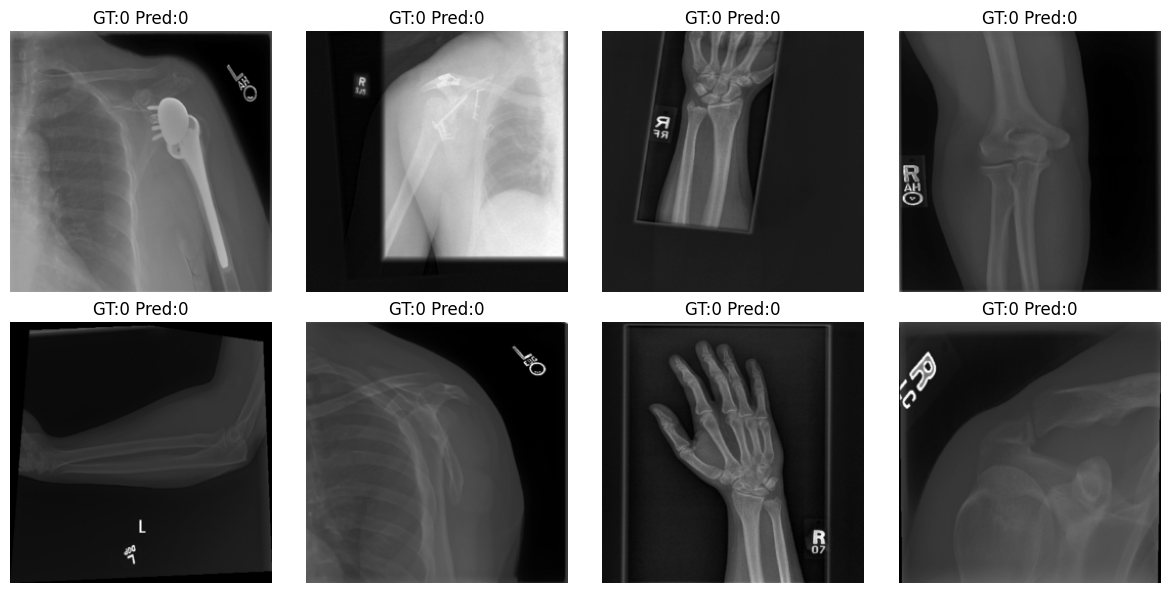

In [10]:
# ✅ 9. Plot predictions
# ==============================================
img, label = next(iter(test_loader))
img, label = img.to(device), label.to(device)
with torch.no_grad():
    pred = model(img)
    _, pred_label = torch.max(pred, 1)

plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(img[i][0].cpu(), cmap='gray')
    plt.title(f"GT:{label[i].item()} Pred:{pred_label[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [11]:
# ✅ 10. Download best model
# ==============================================
from google.colab import files
files.download("/content/best_mura_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>